<a href="https://colab.research.google.com/github/possakorn/UoA_DL_2023_3_PK/blob/main/Assignment02_v3.0.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessment 2: CNNs for image classification

## Setup: import lib

In [15]:
## section: Data manioulation
import math
import pandas as pd
import numpy as np
import random
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## section: neural network
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR

from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
  worker = 4
else:
  worker = 0
print('Using device:', device, 'Using number of workers: ', worker)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

# Set the seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

Using device: cuda Using number of workers:  4

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


## Step01: Data exploration

In [3]:
## Download from cifar10
dataset = 'FashionMNIST' # change this one
set_seed(1311)
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download = True,
    transform= transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((32, 32)),  # Resize all images to 64x64
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download = True,
    transform= transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((32, 32)),  # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

100%|██████████| 26421880/26421880 [00:02<00:00, 12655526.66it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202623.88it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3780668.10it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6739162.61it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### Exploratory Image analysis

Check Shape of images:  torch.Size([3, 32, 32]) 3
Preview Images with Label : T-shirt/top
Show of images unique 10 labels:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


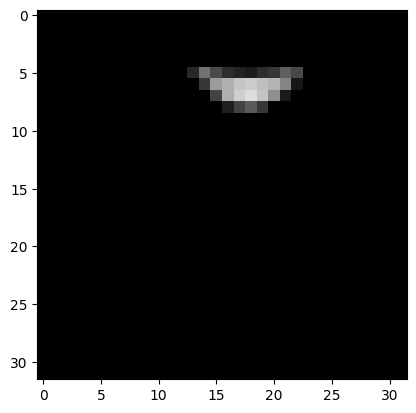

In [4]:
## check shape and labels
img, label = training_data[3]
print("Check Shape of images: ",img.shape,label)

def display_img(img,label):
  print(f"Preview Images with Label : {training_data.classes[label]}")
  plt.imshow(img.permute(1,2,0)) # for visualization following the plt need to change the shapes

#display the first image in the dataset
display_img(*training_data[2])

#Show all labels
classes = training_data.classes
num_class = len(classes)
print(f"Show of images unique {num_class} labels: ",classes)


### Tranforms to Dataloader

In [5]:
batch_size = 16

## setting the split configuration
set_seed(1311)
train_size = int(0.8 * len(training_data))
val_size = len(training_data) - train_size
training_data, val_data = random_split(training_data, [train_size, val_size])

## apply the dataloader
set_seed(1311)

trainloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=worker,
    pin_memory = True
    )
valloader = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=worker,
    pin_memory = True
    )
testloader = torch.utils.data.DataLoader(
    testing_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=worker,
    pin_memory = True
    )

# check the splitting
num_items_train = len(trainloader.dataset)
num_items_val = len(valloader.dataset)
num_items_test = len(testloader.dataset)

num_batches_train = len(trainloader)
num_batches_val = len(valloader)
num_batches_test = len(testloader)

print("Training set: {} items, {} batches".format(num_items_train, num_batches_train))
print("Validation set: {} items, {} batches".format(num_items_val, num_batches_val))
print("Test set: {} items, {} batches".format(num_items_test, num_batches_test))

Training set: 48000 items, 3000 batches
Validation set: 12000 items, 750 batches
Test set: 10000 items, 625 batches


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Review the Batch fig and size

torch.Size([16, 3, 32, 32])


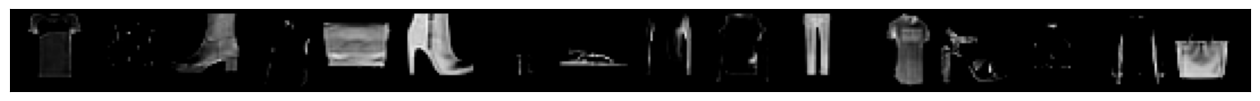

In [6]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

## show the batch fig
show_batch(trainloader)

## print the size
for batch in trainloader:
    print(batch[0].shape)  # Assuming batch[0] contains the data and batch[1] contains the labels
    break

## Base Model Functions For Image Classification

In [7]:
import time
from tqdm import tqdm

def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(trainloader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels.data)
        total_train += labels.size(0)

    epoch_loss = running_loss / total_train
    epoch_acc = correct_train.double() / total_train
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

    loss = running_loss / total
    accuracy = correct.double() / total
    return loss, accuracy


def train_network(model, optimizer, criterion, scheduler, trainloader, valloader, testloader, num_epochs, device, num_class, model_name, dataset):
    set_seed(1311)
    ## Set up the path for saving the model
    PATH = f'./{dataset}_{model_name}.pth'
    print('Model will be saved to:', PATH)
    print('Using device:', device, 'with seed: 1311')
    print()

    ## Initialize variables
    best_val_acc = 0  # to track the best validation accuracy
    # create set to collect the output
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
    }

    class_correct = list(0. for i in range(num_class))
    class_total = list(0. for i in range(num_class))

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, valloader, criterion, device)


        # Step the scheduler with the validation loss
        scheduler.step()
        # scheduler.step(val_acc) # for ReduceLROnPlateau

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(100 * train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(100 * val_acc)

        # Save the model if it has improved on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), PATH)
            print(f'Model improved and saved to {PATH}')

        # print epoch results
        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {100 * train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {100 * val_acc:.2f}%, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')

    print('Training complete. Evaluating on test set with the best model...')

    # Load the best model for final evaluation on test set
    best_model = model
    best_model.load_state_dict(torch.load(PATH))
    test_loss, test_acc = evaluate(best_model, testloader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {100 * test_acc:.2f}%')

    # Add test results to history
    history['test_loss'] = test_loss
    history['test_accuracy'] = 100 * test_acc

    return history

## Initialize network

### network: SimpleCNN

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=num_class):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### network: Alexnet

In [9]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=num_class):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



### network: VGG19

In [10]:
__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


class VGG(nn.Module):
    '''
    VGG model
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
          512, 512, 512, 512, 'M'],
}


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn():
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True))


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

### network: ResNet18

In [11]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size=3, stride=stride, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size=3,stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=num_class):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

## Train the network

In [12]:
def plot_loss(train_loss, val_loss):
    if isinstance(train_loss[0], torch.Tensor):
        train_loss = [x.cpu().numpy() for x in train_loss]
    if isinstance(val_loss[0], torch.Tensor):
        val_loss = [x.cpu().numpy() for x in val_loss]

    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

def plot_acc(train_acc, val_acc):
    if isinstance(train_acc[0], torch.Tensor):
        train_acc = [x.cpu().numpy() for x in train_acc]
    if isinstance(val_acc[0], torch.Tensor):
        val_acc = [x.cpu().numpy() for x in val_acc]

    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

In [13]:
# set the whole network training
num_epochs = 20
criterion = nn.CrossEntropyLoss()


### Train the network - simpleCNN

Model will be saved to: ./FashionMNIST_simplecnn.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 750/750 [00:07<00:00, 103.65it/s]


Model improved and saved to ./FashionMNIST_simplecnn.pth
Epoch 1/20, Train Loss: 1.0580, Train Acc: 60.03%, Val Loss: 0.7096, Val Acc: 72.26%, Time: 51.64s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 85.83it/s] 


Model improved and saved to ./FashionMNIST_simplecnn.pth
Epoch 2/20, Train Loss: 0.6527, Train Acc: 74.87%, Val Loss: 0.5905, Val Acc: 77.07%, Time: 45.09s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 75.48it/s]


Model improved and saved to ./FashionMNIST_simplecnn.pth
Epoch 3/20, Train Loss: 0.5643, Train Acc: 78.31%, Val Loss: 0.5307, Val Acc: 79.38%, Time: 45.31s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 86.40it/s] 


Model improved and saved to ./FashionMNIST_simplecnn.pth
Epoch 4/20, Train Loss: 0.5075, Train Acc: 80.57%, Val Loss: 0.4836, Val Acc: 80.99%, Time: 50.58s


Evaluating: 100%|██████████| 750/750 [00:07<00:00, 100.73it/s]


Model improved and saved to ./FashionMNIST_simplecnn.pth
Epoch 5/20, Train Loss: 0.4600, Train Acc: 82.59%, Val Loss: 0.4414, Val Acc: 83.25%, Time: 44.25s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 85.72it/s] 


Model improved and saved to ./FashionMNIST_simplecnn.pth
Epoch 6/20, Train Loss: 0.4248, Train Acc: 84.07%, Val Loss: 0.4101, Val Acc: 84.33%, Time: 46.12s


Evaluating: 100%|██████████| 750/750 [00:07<00:00, 96.01it/s] 


Model improved and saved to ./FashionMNIST_simplecnn.pth
Epoch 7/20, Train Loss: 0.4002, Train Acc: 84.94%, Val Loss: 0.3800, Val Acc: 85.96%, Time: 45.35s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 85.69it/s]


Model improved and saved to ./FashionMNIST_simplecnn.pth
Epoch 8/20, Train Loss: 0.3784, Train Acc: 85.93%, Val Loss: 0.3715, Val Acc: 86.05%, Time: 45.66s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 85.68it/s] 


Model improved and saved to ./FashionMNIST_simplecnn.pth
Epoch 9/20, Train Loss: 0.3615, Train Acc: 86.41%, Val Loss: 0.3618, Val Acc: 86.93%, Time: 44.53s


Evaluating: 100%|██████████| 750/750 [00:07<00:00, 101.34it/s]


Model improved and saved to ./FashionMNIST_simplecnn.pth
Epoch 10/20, Train Loss: 0.3486, Train Acc: 86.89%, Val Loss: 0.3487, Val Acc: 86.98%, Time: 45.03s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 84.89it/s] 


Model improved and saved to ./FashionMNIST_simplecnn.pth
Epoch 11/20, Train Loss: 0.3375, Train Acc: 87.39%, Val Loss: 0.3378, Val Acc: 87.24%, Time: 45.64s


Evaluating: 100%|██████████| 750/750 [00:07<00:00, 97.99it/s] 


Model improved and saved to ./FashionMNIST_simplecnn.pth
Epoch 12/20, Train Loss: 0.3242, Train Acc: 87.85%, Val Loss: 0.3204, Val Acc: 87.81%, Time: 44.49s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 84.65it/s]


Model improved and saved to ./FashionMNIST_simplecnn.pth
Epoch 13/20, Train Loss: 0.3158, Train Acc: 88.07%, Val Loss: 0.3208, Val Acc: 88.18%, Time: 46.83s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 91.43it/s] 


Model improved and saved to ./FashionMNIST_simplecnn.pth
Epoch 14/20, Train Loss: 0.3082, Train Acc: 88.49%, Val Loss: 0.2972, Val Acc: 89.38%, Time: 45.15s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 85.81it/s]


Epoch 15/20, Train Loss: 0.3015, Train Acc: 88.78%, Val Loss: 0.3033, Val Acc: 88.77%, Time: 46.24s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 86.41it/s]


Epoch 16/20, Train Loss: 0.2944, Train Acc: 89.09%, Val Loss: 0.2917, Val Acc: 89.27%, Time: 45.35s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 84.42it/s]


Epoch 17/20, Train Loss: 0.2876, Train Acc: 89.24%, Val Loss: 0.2959, Val Acc: 89.31%, Time: 46.77s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 87.46it/s]


Epoch 18/20, Train Loss: 0.2819, Train Acc: 89.42%, Val Loss: 0.2883, Val Acc: 89.31%, Time: 45.42s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 85.73it/s]


Epoch 19/20, Train Loss: 0.2771, Train Acc: 89.74%, Val Loss: 0.2881, Val Acc: 89.38%, Time: 46.27s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 83.77it/s] 


Model improved and saved to ./FashionMNIST_simplecnn.pth
Epoch 20/20, Train Loss: 0.2721, Train Acc: 89.83%, Val Loss: 0.2872, Val Acc: 89.46%, Time: 45.27s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:05<00:00, 110.09it/s]


Test Loss: 0.2655, Test Acc: 90.46%


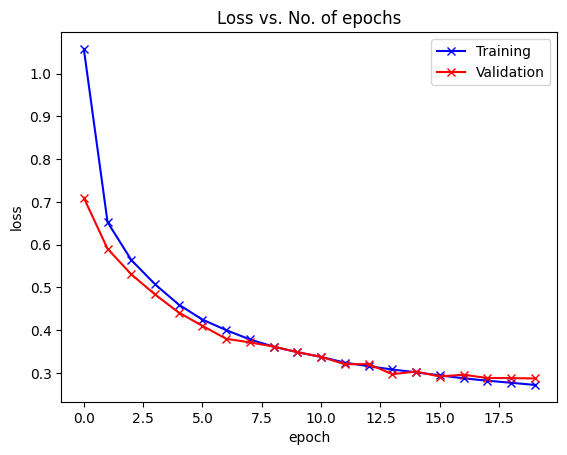

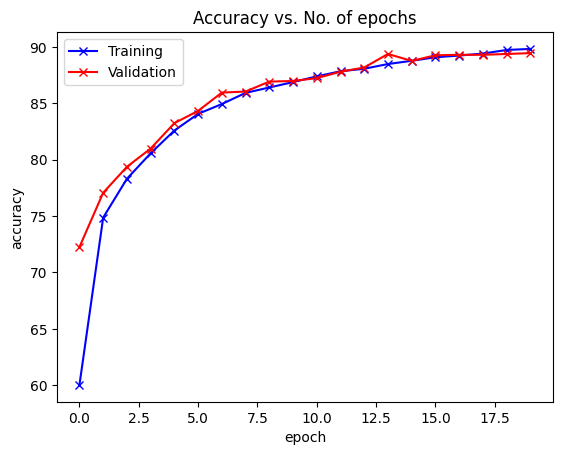

Test Loss: 0.2655, Test Accuracy: 90.46%


In [13]:
# individual configuration
simplecnn = SimpleCNN().to(device)
model_name = "simplecnn"
model = simplecnn
# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
simplecnn_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(simplecnn_results['train_loss'], simplecnn_results['val_loss'])
plot_acc(simplecnn_results['train_accuracy'], simplecnn_results['val_accuracy'])
# Print Test Loss and Test Accuracy
print(f'Test Loss: {simplecnn_results["test_loss"]:.4f}, Test Accuracy: {simplecnn_results["test_accuracy"]:.2f}%')

### Train the network - Alexnet

Model will be saved to: ./FashionMNIST_alexnet.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 750/750 [00:09<00:00, 79.61it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 1/20, Train Loss: 1.9754, Train Acc: 24.56%, Val Loss: 0.9646, Val Acc: 63.69%, Time: 65.03s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 83.49it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 2/20, Train Loss: 0.8033, Train Acc: 69.29%, Val Loss: 0.6554, Val Acc: 74.23%, Time: 64.64s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 91.22it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 3/20, Train Loss: 0.6556, Train Acc: 74.61%, Val Loss: 0.5954, Val Acc: 76.78%, Time: 63.57s


Evaluating: 100%|██████████| 750/750 [00:07<00:00, 95.34it/s] 


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 4/20, Train Loss: 0.5809, Train Acc: 77.30%, Val Loss: 0.5446, Val Acc: 78.20%, Time: 63.41s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 92.14it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 5/20, Train Loss: 0.5240, Train Acc: 79.75%, Val Loss: 0.4940, Val Acc: 80.58%, Time: 63.90s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 83.80it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 6/20, Train Loss: 0.4731, Train Acc: 82.07%, Val Loss: 0.4370, Val Acc: 83.56%, Time: 64.05s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 80.74it/s] 


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 7/20, Train Loss: 0.4357, Train Acc: 83.39%, Val Loss: 0.3953, Val Acc: 84.85%, Time: 63.99s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 80.73it/s] 


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 8/20, Train Loss: 0.4067, Train Acc: 84.67%, Val Loss: 0.3859, Val Acc: 85.65%, Time: 64.16s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 82.53it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 9/20, Train Loss: 0.3855, Train Acc: 85.61%, Val Loss: 0.3686, Val Acc: 86.37%, Time: 63.84s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 83.01it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 10/20, Train Loss: 0.3669, Train Acc: 86.29%, Val Loss: 0.3274, Val Acc: 87.43%, Time: 63.81s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 82.45it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 11/20, Train Loss: 0.3501, Train Acc: 86.75%, Val Loss: 0.3242, Val Acc: 87.62%, Time: 63.90s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 91.43it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 12/20, Train Loss: 0.3352, Train Acc: 87.31%, Val Loss: 0.3097, Val Acc: 88.24%, Time: 62.85s


Evaluating: 100%|██████████| 750/750 [00:07<00:00, 95.74it/s] 


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 13/20, Train Loss: 0.3241, Train Acc: 87.81%, Val Loss: 0.3036, Val Acc: 88.92%, Time: 62.78s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 93.67it/s] 


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 14/20, Train Loss: 0.3153, Train Acc: 88.09%, Val Loss: 0.2856, Val Acc: 89.44%, Time: 63.16s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 82.34it/s]


Epoch 15/20, Train Loss: 0.3064, Train Acc: 88.49%, Val Loss: 0.2976, Val Acc: 88.61%, Time: 62.89s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 81.69it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 16/20, Train Loss: 0.3004, Train Acc: 88.78%, Val Loss: 0.2793, Val Acc: 89.55%, Time: 63.30s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 79.91it/s]


Epoch 17/20, Train Loss: 0.2902, Train Acc: 89.20%, Val Loss: 0.2900, Val Acc: 89.31%, Time: 62.98s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 89.24it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 18/20, Train Loss: 0.2848, Train Acc: 89.38%, Val Loss: 0.2761, Val Acc: 89.70%, Time: 63.21s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 93.01it/s]


Epoch 19/20, Train Loss: 0.2791, Train Acc: 89.58%, Val Loss: 0.2837, Val Acc: 89.69%, Time: 62.47s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 91.80it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 20/20, Train Loss: 0.2713, Train Acc: 89.89%, Val Loss: 0.2677, Val Acc: 90.16%, Time: 64.43s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 89.95it/s] 


Test Loss: 0.2585, Test Acc: 90.56%


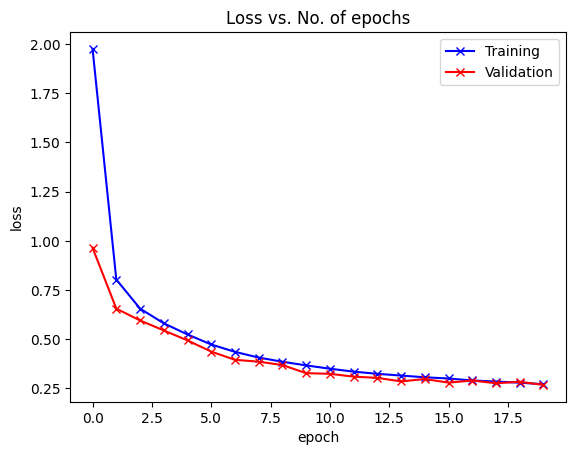

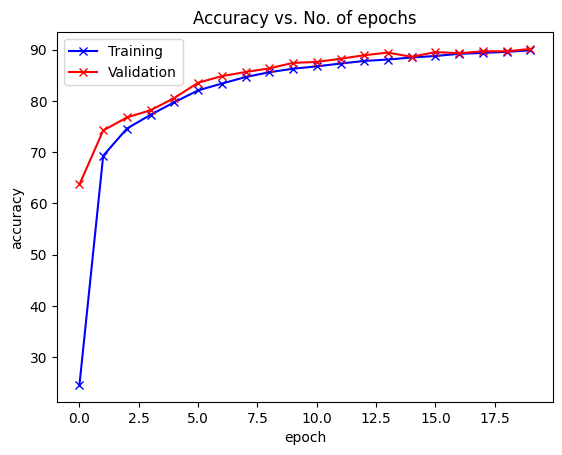

Test Loss: 0.2585, Test Accuracy: 90.56%


In [14]:
# individual configuration
alexnet = AlexNet().to(device)
model_name = "alexnet"
model = alexnet

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)


# training model
alexnet_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(alexnet_results['train_loss'], alexnet_results['val_loss'])
plot_acc(alexnet_results['train_accuracy'], alexnet_results['val_accuracy'])
# Print Test Loss and Test Accuracy
print(f'Test Loss: {alexnet_results["test_loss"]:.4f}, Test Accuracy: {alexnet_results["test_accuracy"]:.2f}%')

### Train the network - VGG19

Model will be saved to: ./FashionMNIST_vggnet18.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 750/750 [00:08<00:00, 84.71it/s]


Model improved and saved to ./FashionMNIST_vggnet18.pth
Epoch 1/20, Train Loss: 1.7875, Train Acc: 30.41%, Val Loss: 0.8884, Val Acc: 65.27%, Time: 81.02s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 77.63it/s]


Model improved and saved to ./FashionMNIST_vggnet18.pth
Epoch 2/20, Train Loss: 0.7902, Train Acc: 70.12%, Val Loss: 0.6715, Val Acc: 73.59%, Time: 75.43s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 77.12it/s]


Model improved and saved to ./FashionMNIST_vggnet18.pth
Epoch 3/20, Train Loss: 0.6519, Train Acc: 75.17%, Val Loss: 0.6199, Val Acc: 75.92%, Time: 75.32s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 79.89it/s]


Model improved and saved to ./FashionMNIST_vggnet18.pth
Epoch 4/20, Train Loss: 0.5820, Train Acc: 77.75%, Val Loss: 0.5482, Val Acc: 78.08%, Time: 75.00s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 91.49it/s]


Model improved and saved to ./FashionMNIST_vggnet18.pth
Epoch 5/20, Train Loss: 0.5317, Train Acc: 79.92%, Val Loss: 0.5057, Val Acc: 81.72%, Time: 73.82s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 85.84it/s]


Model improved and saved to ./FashionMNIST_vggnet18.pth
Epoch 6/20, Train Loss: 0.4946, Train Acc: 81.53%, Val Loss: 0.4699, Val Acc: 82.32%, Time: 74.36s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 80.57it/s]


Model improved and saved to ./FashionMNIST_vggnet18.pth
Epoch 7/20, Train Loss: 0.4685, Train Acc: 82.53%, Val Loss: 0.4372, Val Acc: 83.48%, Time: 74.71s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 78.01it/s]


Epoch 8/20, Train Loss: 0.4448, Train Acc: 83.62%, Val Loss: 0.4476, Val Acc: 83.39%, Time: 74.90s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 79.32it/s]


Model improved and saved to ./FashionMNIST_vggnet18.pth
Epoch 9/20, Train Loss: 0.4251, Train Acc: 84.47%, Val Loss: 0.4123, Val Acc: 84.10%, Time: 74.98s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 90.65it/s]


Model improved and saved to ./FashionMNIST_vggnet18.pth
Epoch 10/20, Train Loss: 0.4070, Train Acc: 84.97%, Val Loss: 0.3951, Val Acc: 85.26%, Time: 74.41s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 85.57it/s]


Model improved and saved to ./FashionMNIST_vggnet18.pth
Epoch 11/20, Train Loss: 0.3907, Train Acc: 85.64%, Val Loss: 0.3547, Val Acc: 86.56%, Time: 74.97s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 77.29it/s]


Model improved and saved to ./FashionMNIST_vggnet18.pth
Epoch 12/20, Train Loss: 0.3730, Train Acc: 86.25%, Val Loss: 0.3718, Val Acc: 86.87%, Time: 75.60s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 79.40it/s]


Epoch 13/20, Train Loss: 0.3640, Train Acc: 86.66%, Val Loss: 0.3601, Val Acc: 86.80%, Time: 74.84s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 79.82it/s]


Model improved and saved to ./FashionMNIST_vggnet18.pth
Epoch 14/20, Train Loss: 0.3548, Train Acc: 87.01%, Val Loss: 0.3296, Val Acc: 87.94%, Time: 74.87s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 91.69it/s]


Epoch 15/20, Train Loss: 0.3439, Train Acc: 87.48%, Val Loss: 0.3396, Val Acc: 87.16%, Time: 73.57s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 85.41it/s]


Epoch 16/20, Train Loss: 0.3346, Train Acc: 87.90%, Val Loss: 0.3351, Val Acc: 87.53%, Time: 74.47s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 80.56it/s] 


Model improved and saved to ./FashionMNIST_vggnet18.pth
Epoch 17/20, Train Loss: 0.3256, Train Acc: 88.12%, Val Loss: 0.3288, Val Acc: 88.14%, Time: 75.07s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 80.11it/s]


Model improved and saved to ./FashionMNIST_vggnet18.pth
Epoch 18/20, Train Loss: 0.3179, Train Acc: 88.44%, Val Loss: 0.3101, Val Acc: 88.62%, Time: 74.83s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 80.26it/s]


Epoch 19/20, Train Loss: 0.3114, Train Acc: 88.65%, Val Loss: 0.3145, Val Acc: 88.52%, Time: 74.76s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 91.47it/s]


Model improved and saved to ./FashionMNIST_vggnet18.pth
Epoch 20/20, Train Loss: 0.3063, Train Acc: 88.83%, Val Loss: 0.3038, Val Acc: 88.96%, Time: 73.82s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 89.13it/s] 


Test Loss: 0.2835, Test Acc: 90.07%


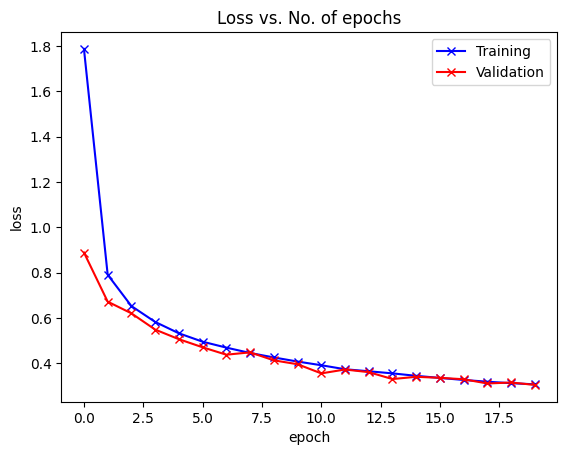

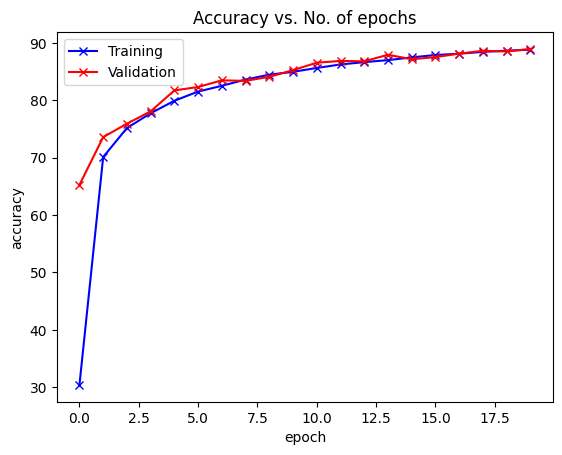

In [16]:
# individual configuration
vggnet18 = vgg19().to(device)
model_name = "vggnet18"
model = vggnet18

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
vggnet18_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(vggnet18_results['train_loss'], vggnet18_results['val_loss'])
plot_acc(vggnet18_results['train_accuracy'], vggnet18_results['val_accuracy'])

### Train the network - Resnet18

Model will be saved to: ./FashionMNIST_resnet18.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 750/750 [00:10<00:00, 70.94it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 1/20, Train Loss: 0.5895, Train Acc: 78.22%, Val Loss: 0.3950, Val Acc: 85.74%, Time: 89.90s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 72.07it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 2/20, Train Loss: 0.3668, Train Acc: 86.53%, Val Loss: 0.2903, Val Acc: 89.37%, Time: 89.23s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 72.10it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 3/20, Train Loss: 0.3133, Train Acc: 88.52%, Val Loss: 0.2766, Val Acc: 90.06%, Time: 88.80s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 75.87it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 4/20, Train Loss: 0.2812, Train Acc: 89.81%, Val Loss: 0.2426, Val Acc: 91.29%, Time: 88.29s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 81.05it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 5/20, Train Loss: 0.2568, Train Acc: 90.51%, Val Loss: 0.2311, Val Acc: 91.55%, Time: 87.50s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 77.36it/s]


Epoch 6/20, Train Loss: 0.2424, Train Acc: 91.16%, Val Loss: 0.2317, Val Acc: 91.52%, Time: 88.42s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 72.65it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 7/20, Train Loss: 0.2291, Train Acc: 91.55%, Val Loss: 0.2166, Val Acc: 92.07%, Time: 88.51s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 71.92it/s]


Epoch 8/20, Train Loss: 0.2178, Train Acc: 91.93%, Val Loss: 0.2492, Val Acc: 90.66%, Time: 88.65s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 71.33it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 9/20, Train Loss: 0.2095, Train Acc: 92.29%, Val Loss: 0.2167, Val Acc: 92.45%, Time: 89.14s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 71.78it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 10/20, Train Loss: 0.2027, Train Acc: 92.40%, Val Loss: 0.2035, Val Acc: 92.75%, Time: 88.71s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 72.72it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 11/20, Train Loss: 0.1971, Train Acc: 92.67%, Val Loss: 0.2017, Val Acc: 92.84%, Time: 88.65s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 77.39it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 12/20, Train Loss: 0.1866, Train Acc: 93.02%, Val Loss: 0.1951, Val Acc: 93.04%, Time: 88.35s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 81.70it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 13/20, Train Loss: 0.1802, Train Acc: 93.45%, Val Loss: 0.1961, Val Acc: 93.20%, Time: 88.28s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 76.78it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 14/20, Train Loss: 0.1729, Train Acc: 93.54%, Val Loss: 0.1815, Val Acc: 93.47%, Time: 88.68s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 72.50it/s]


Epoch 15/20, Train Loss: 0.1696, Train Acc: 93.82%, Val Loss: 0.1996, Val Acc: 92.71%, Time: 88.80s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 69.02it/s]


Epoch 16/20, Train Loss: 0.1616, Train Acc: 93.97%, Val Loss: 0.1796, Val Acc: 93.47%, Time: 90.09s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 69.19it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 17/20, Train Loss: 0.1555, Train Acc: 94.25%, Val Loss: 0.1801, Val Acc: 93.71%, Time: 92.00s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 70.79it/s]


Epoch 18/20, Train Loss: 0.1540, Train Acc: 94.29%, Val Loss: 0.1879, Val Acc: 93.07%, Time: 92.44s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 71.78it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 19/20, Train Loss: 0.1477, Train Acc: 94.69%, Val Loss: 0.1801, Val Acc: 93.82%, Time: 90.90s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 75.88it/s]


Epoch 20/20, Train Loss: 0.1427, Train Acc: 94.70%, Val Loss: 0.1795, Val Acc: 93.68%, Time: 89.44s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 79.97it/s]


Test Loss: 0.1806, Test Acc: 93.66%


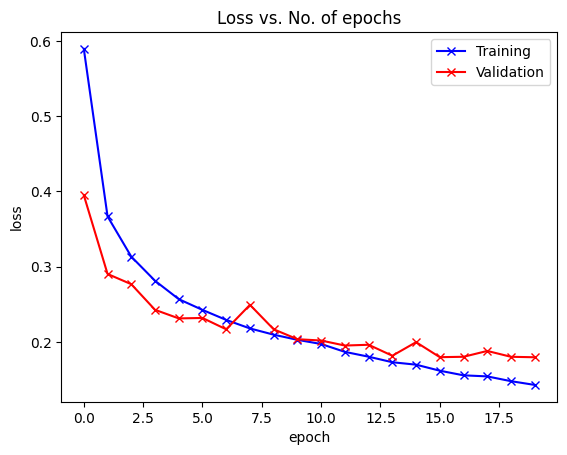

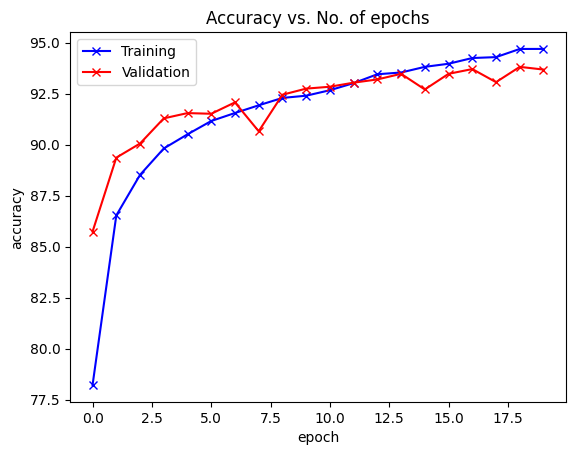

In [15]:
# individual configuration
resnet18 = ResNet18().to(device)
model_name = "resnet18"
model = resnet18

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
resnet18_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(resnet18_results['train_loss'], resnet18_results['val_loss'])
plot_acc(resnet18_results['train_accuracy'], resnet18_results['val_accuracy'])

### Train the network - Resnet34

Model will be saved to: ./FashionMNIST_resnet34.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 750/750 [00:12<00:00, 59.75it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 1/20, Train Loss: 0.5851, Train Acc: 78.47%, Val Loss: 0.3961, Val Acc: 85.63%, Time: 142.53s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 60.28it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 2/20, Train Loss: 0.3627, Train Acc: 86.87%, Val Loss: 0.2987, Val Acc: 89.34%, Time: 142.09s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 61.67it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 3/20, Train Loss: 0.3092, Train Acc: 88.87%, Val Loss: 0.2742, Val Acc: 90.17%, Time: 142.12s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 59.83it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 4/20, Train Loss: 0.2794, Train Acc: 89.80%, Val Loss: 0.2483, Val Acc: 91.28%, Time: 142.81s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 60.52it/s]


Epoch 5/20, Train Loss: 0.2542, Train Acc: 90.61%, Val Loss: 0.2428, Val Acc: 90.92%, Time: 142.09s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 60.13it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 6/20, Train Loss: 0.2410, Train Acc: 91.25%, Val Loss: 0.2273, Val Acc: 91.76%, Time: 142.06s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 59.93it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 7/20, Train Loss: 0.2269, Train Acc: 91.70%, Val Loss: 0.2162, Val Acc: 92.15%, Time: 142.80s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 60.04it/s]


Epoch 8/20, Train Loss: 0.2162, Train Acc: 92.01%, Val Loss: 0.2586, Val Acc: 90.76%, Time: 142.14s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 62.29it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 9/20, Train Loss: 0.2062, Train Acc: 92.48%, Val Loss: 0.2026, Val Acc: 92.70%, Time: 142.34s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 60.40it/s]


Epoch 10/20, Train Loss: 0.2004, Train Acc: 92.60%, Val Loss: 0.2061, Val Acc: 92.62%, Time: 142.23s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 59.84it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 11/20, Train Loss: 0.1964, Train Acc: 92.80%, Val Loss: 0.1952, Val Acc: 92.96%, Time: 142.63s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 60.45it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 12/20, Train Loss: 0.1863, Train Acc: 93.16%, Val Loss: 0.1913, Val Acc: 93.36%, Time: 142.22s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 59.79it/s]


Epoch 13/20, Train Loss: 0.1807, Train Acc: 93.54%, Val Loss: 0.1924, Val Acc: 93.31%, Time: 142.43s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 59.88it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 14/20, Train Loss: 0.1747, Train Acc: 93.66%, Val Loss: 0.1837, Val Acc: 93.42%, Time: 142.44s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 60.49it/s]


Epoch 15/20, Train Loss: 0.1683, Train Acc: 93.85%, Val Loss: 0.1965, Val Acc: 92.88%, Time: 142.38s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 60.62it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 16/20, Train Loss: 0.1619, Train Acc: 94.09%, Val Loss: 0.1783, Val Acc: 93.57%, Time: 143.12s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 60.18it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 17/20, Train Loss: 0.1541, Train Acc: 94.40%, Val Loss: 0.1796, Val Acc: 93.77%, Time: 142.81s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 59.81it/s]


Epoch 18/20, Train Loss: 0.1536, Train Acc: 94.37%, Val Loss: 0.1820, Val Acc: 93.38%, Time: 142.37s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 59.66it/s]


Epoch 19/20, Train Loss: 0.1477, Train Acc: 94.54%, Val Loss: 0.1891, Val Acc: 93.55%, Time: 142.90s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 59.43it/s]


Epoch 20/20, Train Loss: 0.1421, Train Acc: 94.78%, Val Loss: 0.1783, Val Acc: 93.68%, Time: 142.86s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 65.34it/s]


Test Loss: 0.1873, Test Acc: 93.51%


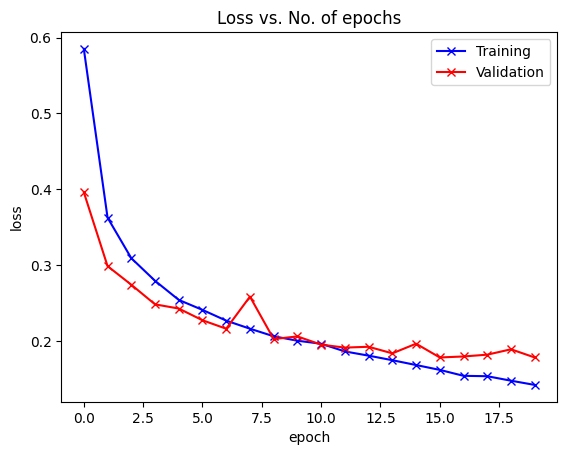

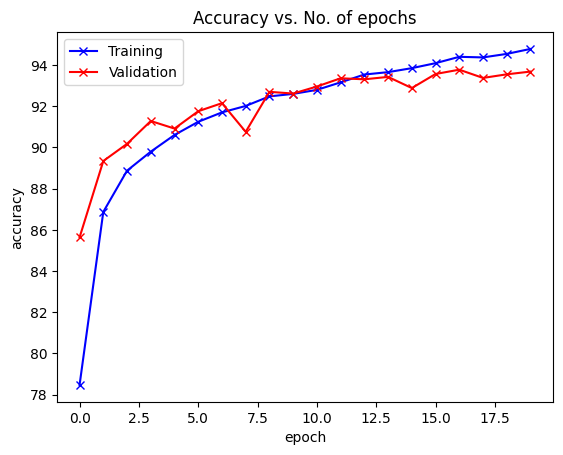

In [16]:
# individual configuration
resnet34 = ResNet34().to(device)
model_name = "resnet34"
model = resnet34

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
resnet34_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )


# Plot the results
plot_loss(resnet34_results['train_loss'], resnet34_results['val_loss'])
plot_acc(resnet34_results['train_accuracy'], resnet34_results['val_accuracy'])

### Train the network - Resnet50

Model will be saved to: ./FashionMNIST_resnet50.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.19it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 1/20, Train Loss: 0.7337, Train Acc: 73.76%, Val Loss: 0.4223, Val Acc: 84.26%, Time: 230.80s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 50.17it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 2/20, Train Loss: 0.4228, Train Acc: 84.64%, Val Loss: 0.3209, Val Acc: 88.46%, Time: 230.59s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 50.33it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 3/20, Train Loss: 0.3517, Train Acc: 87.43%, Val Loss: 0.3115, Val Acc: 88.62%, Time: 230.32s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.19it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 4/20, Train Loss: 0.3094, Train Acc: 88.83%, Val Loss: 0.2626, Val Acc: 90.42%, Time: 229.59s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.42it/s]


Epoch 5/20, Train Loss: 0.2795, Train Acc: 89.87%, Val Loss: 0.2718, Val Acc: 90.13%, Time: 229.33s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.51it/s]


Epoch 6/20, Train Loss: 0.2589, Train Acc: 90.61%, Val Loss: 0.2872, Val Acc: 89.65%, Time: 228.97s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.37it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 7/20, Train Loss: 0.2458, Train Acc: 91.04%, Val Loss: 0.2442, Val Acc: 91.34%, Time: 229.40s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.71it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 8/20, Train Loss: 0.2326, Train Acc: 91.57%, Val Loss: 0.2339, Val Acc: 91.59%, Time: 229.78s


Evaluating: 100%|██████████| 750/750 [00:15<00:00, 49.19it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 9/20, Train Loss: 0.2207, Train Acc: 92.06%, Val Loss: 0.2126, Val Acc: 92.43%, Time: 230.52s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.73it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 10/20, Train Loss: 0.2129, Train Acc: 92.17%, Val Loss: 0.2075, Val Acc: 92.66%, Time: 229.61s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.81it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 11/20, Train Loss: 0.2071, Train Acc: 92.41%, Val Loss: 0.2051, Val Acc: 92.94%, Time: 229.26s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.81it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 12/20, Train Loss: 0.1963, Train Acc: 92.75%, Val Loss: 0.1899, Val Acc: 93.27%, Time: 229.59s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.62it/s]


Epoch 13/20, Train Loss: 0.1912, Train Acc: 93.05%, Val Loss: 0.2004, Val Acc: 93.18%, Time: 229.32s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.26it/s]


Epoch 14/20, Train Loss: 0.1827, Train Acc: 93.31%, Val Loss: 0.1904, Val Acc: 93.22%, Time: 229.70s


Evaluating: 100%|██████████| 750/750 [00:15<00:00, 49.12it/s]


Epoch 15/20, Train Loss: 0.1770, Train Acc: 93.55%, Val Loss: 0.1940, Val Acc: 92.93%, Time: 230.76s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.27it/s]


Epoch 16/20, Train Loss: 0.1722, Train Acc: 93.67%, Val Loss: 0.1929, Val Acc: 93.10%, Time: 229.89s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 50.63it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 17/20, Train Loss: 0.1649, Train Acc: 93.99%, Val Loss: 0.1834, Val Acc: 93.72%, Time: 230.68s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.15it/s]


Epoch 18/20, Train Loss: 0.1616, Train Acc: 94.06%, Val Loss: 0.1913, Val Acc: 93.09%, Time: 229.55s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.23it/s]


Epoch 19/20, Train Loss: 0.1579, Train Acc: 94.28%, Val Loss: 0.1967, Val Acc: 93.38%, Time: 229.91s


Evaluating: 100%|██████████| 750/750 [00:15<00:00, 49.71it/s]


Epoch 20/20, Train Loss: 0.1521, Train Acc: 94.49%, Val Loss: 0.1838, Val Acc: 93.62%, Time: 229.80s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:11<00:00, 52.95it/s]


Test Loss: 0.1850, Test Acc: 93.60%


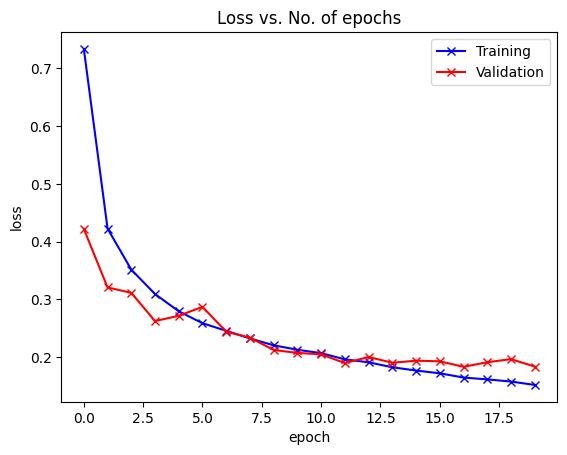

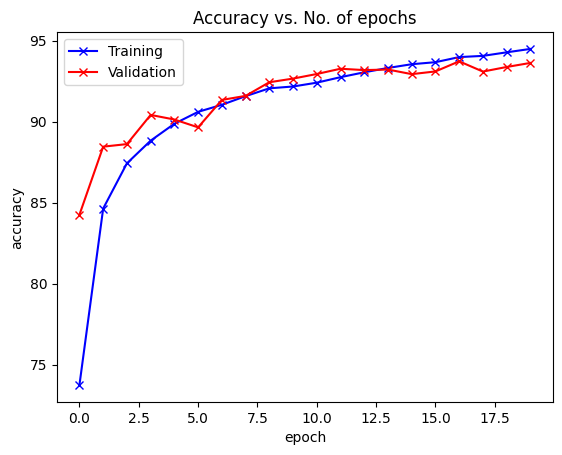

In [17]:
# individual configuration
resnet50 = ResNet50().to(device)
model_name = "resnet50"
model = resnet50

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
resnet50_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(resnet50_results['train_loss'], resnet50_results['val_loss'])
plot_acc(resnet50_results['train_accuracy'], resnet50_results['val_accuracy'])

## Load the Model